## Imports

In [ ]:
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [ ]:
# !pip install wandb -q --upgrade
# !pip install texthero -q --upgrade
# !pip install datasets -q --upgrade
# !pip install transformers -q --upgrade
# !pip install torch_snippets -q --upgrade
# !pip install pytorch-lightning -q --upgrade

In [ ]:
import os
import csv
import glob
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import transformers
import tensorflow as tf
import torchmetrics as tm
import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader

from texthero import clean
from torch_snippets import *
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

2021-08-01 01:49:41.160 | WARNING  | torch_snippets:<module>:9 - torch is not found. Skipping relevant imports from submodule `torch_loader`
Exception: cannot import name 'makedir' from 'torch_snippets.loader' (/usr/local/lib/python3.7/dist-packages/torch_snippets/loader.py)
2021-08-01 01:49:41.164 | WARNING  | torch_snippets:<module>:14 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


## Config

In [ ]:
class Config:
  SEED = 1234
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

  dataset = '/content/drive/MyDrive/AmazonML/input/dataset/train.csv'
  debug = False

  max_len = 250

  model = 'klue/roberta-small'
  epochs = 5
  batch_size = 16 * 8


config = Config()

## Loading the data

In [ ]:
df = pd.read_csv(config.dataset, escapechar='\\', quoting=csv.QUOTE_NONE)

In [ ]:
df.fillna('nan', inplace=True)
df.head(2)

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID
0,"Pete The Cat Bedtime Blues Doll, 14.5 Inch","Pete the Cat is the coolest, most popular cat ...","[Pete the Cat Bedtime Blues plush doll,Based o...",MerryMakers,0
1,"The New Yorker NYHM014 Refrigerator Magnet, 2 ...",The New Yorker Handsome Cello Wrapped Hard Mag...,[Cat In A Tea Cup by New Yorker cover artist G...,The New Yorker,1


## EDA

In [ ]:
temp = df.BROWSE_NODE_ID.value_counts()
value_counts = {}
for i, j in zip(temp.index, temp):
  value_counts[i] = j

In [ ]:
df['BROWSE_NODE_ID'].nunique()

9919

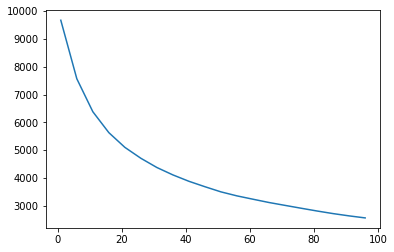

In [ ]:
values = []
ranges = []
for i in range(1,100,5):
    values.append(np.sum(df.BROWSE_NODE_ID.value_counts() > i))
    ranges.append(i)
    
sns.lineplot(x=ranges, y=values)

In [ ]:
df['Threshold'] = df['BROWSE_NODE_ID'].map(lambda x: 1 if value_counts[x] >= 300 else 0)

In [ ]:
np.sum(df['Threshold']) / len(df) # dataset percentage coverage

0.8698092058487976

In [ ]:
df['label'] = df['BROWSE_NODE_ID'] * df['Threshold']
df['label'].nunique() # How many classes we have in the threshold

1299

In [ ]:
# Let's train only on these thresholds
df = df[df['Threshold'] == 1]

In [ ]:
# Brands
df['BRAND'].nunique() # let's leave it aside for now

216221

## Preprocessing the dataset

### Sampling the dataset

In [ ]:
new_df = df.groupby('BROWSE_NODE_ID').sample(300, random_state=1234).reset_index(drop=True) # Limiting each class occurance
new_df = new_df.sample(frac=1, random_state=1234).reset_index(drop=True) # Shuffling the dataset

# label encoding
le = LabelEncoder()
le.fit(new_df['BROWSE_NODE_ID'])
transformed = le.transform(new_df['BROWSE_NODE_ID'])

inverse = {}
for i, j in zip(transformed, new_df['BROWSE_NODE_ID'].values):
  inverse[i] = j

new_df['label'] = transformed
num_classes = new_df['label'].nunique()

In [ ]:
new_df.head()

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID,Threshold,label
0,Arshia Fashions Modal Dress (GR00340B_Blue_7-8...,nan,"[Brand: arshia fashions,Material: rayon,Color ...",Arshia Fashions,1517,1,528
1,Candere By Kalyan Jewellers 18KT Yellow Gold R...,nan,"[The product is set in 18k gold, verified by B...",Candere By Kalyan Jewellers,969,1,374
2,AutoStark Car Exhaust Turbine Style Silencer M...,nan,Dimensions of the product mentioned here is no...,AutoStark,3587,1,827
3,Posterpot Marvel Thor Ragnarok (Large Plastic ...,Posterpot present fabulous Digital Large Print...,"[Stunningly sharp digital printing ,Now start ...",POSTERPOT,413,1,169
4,Toiing Craftoi Kathakali - 3D DIY Paper Craft ...,nan,[WHAT'S INSIDE: Pre-cut sheets and an illustra...,Toiing,202,1,87


### EDA on counts

In [ ]:
# Looking the word counts

new_df['title_len'] = new_df['TITLE'].map(len)
new_df['des_len'] = new_df['DESCRIPTION'].map(len)
new_df['bp_len'] = new_df['BULLET_POINTS'].map(len)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



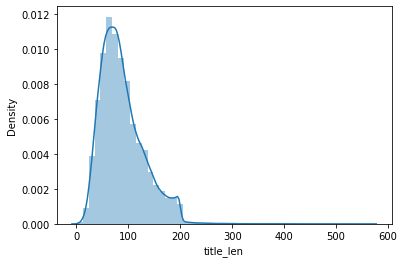

In [ ]:
sns.distplot(new_df['title_len'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



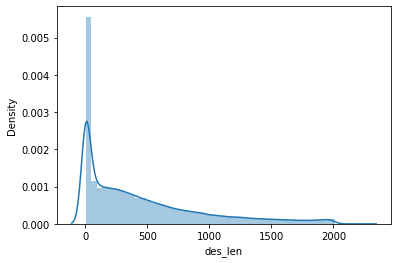

In [ ]:
sns.distplot(new_df['des_len'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



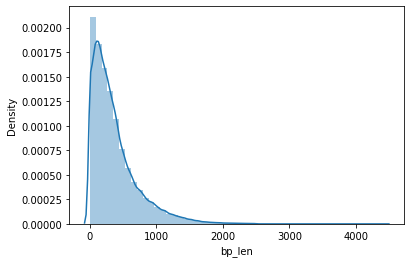

In [ ]:
sns.distplot(new_df['bp_len'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



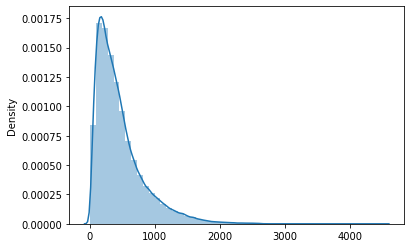

In [ ]:
sns.distplot(new_df['title_len'] + new_df['bp_len'])

### Cleaning the dataset

In [ ]:
%%time
new_df['TITLE'] = clean(new_df['TITLE'])
new_df['BULLET_POINTS'] = clean(new_df['BULLET_POINTS'])

CPU times: user 59.2 s, sys: 1.2 s, total: 1min
Wall time: 1min


### Splitting the dataset

In [ ]:
train_df, valid_df = train_test_split(new_df, stratify=new_df['label'], random_state=1234)

### Observation:


*   700 should be a reasonable length
*   Now we will train a model with title + bullet_points



## Creating the dataset

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained(config.model)

In [ ]:
sample = tokenizer.encode_plus(train_df['TITLE'][0], train_df['BULLET_POINTS'][0])
tokenizer.decode(sample['input_ids'])

'[CLS] arshia fashions modal dress gr00340b blue 7 years [SEP] brand arshia fashions material rayon color name blue dry clean target audience girl size years package contents x modal dress [SEP]'

In [ ]:
class TrainDataset(Dataset):
  def __init__(self, df, tokenizer):
    self.titles = df['TITLE'].values
    self.bp     = df['BULLET_POINTS'].values
    self.tokenizer = tokenizer
    self.targets = df['label'].values

  def __len__(self):
    return len(self.titles)

  def __getitem__(self, idx):
    title = self.titles[idx]
    bp = self.bp[idx]
    target = self.targets[idx]

    inputs = self.tokenizer.encode_plus(
        title, bp,
        add_special_tokens=True,
        max_length = config.max_len,
        truncation = True,
        padding = True
    )

    ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    mask = inputs['attention_mask']

    padding_len = config.max_len - len(ids)
    ids =  ids + ([0] * padding_len)
    token_type_ids = token_type_ids + ([0] * padding_len)
    mask = mask + ([0] * padding_len)

    return {'ids':torch.tensor(ids, dtype=torch.long),
            'mask':torch.tensor(mask, dtype=torch.long),
            'ttids':torch.tensor(token_type_ids, dtype=torch.long),
            'targets':torch.tensor(target, dtype=torch.long)}

In [ ]:
train_ds = TrainDataset(train_df, tokenizer)
valid_ds = TrainDataset(valid_df, tokenizer)

train_dl = DataLoader(train_ds,
                      batch_size=config.batch_size,
                      num_workers=4,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size=config.batch_size,
                      num_workers=4,
                      pin_memory=True)

In [ ]:
for i in train_dl:
  print(i['ids'].shape)
  break

torch.Size([128, 250])


## Creating Model

In [ ]:
class AmazonModel(pl.LightningModule):
  def __init__(self):
    super(AmazonModel, self).__init__()
    self.base_model = transformers.BertModel.from_pretrained(config.model)
    self.classifier = torch.nn.Linear(self.base_model.pooler.dense.out_features, num_classes)
    self.loss = torch.nn.CrossEntropyLoss()
    self.acc = tm.Accuracy()
    self.softmax = torch.nn.functional.softmax()
  
  def forward(self, ids, mask, ttids):
    out = self.base_model(ids, attention_mask=mask, token_type_ids=ttids)
    out = self.classifier(out.pooler_output)
    return self.softmax(out)

  def training_step(self, batch, batch_nb):
    ids, mask, ttids, targets = batch['ids'], batch['mask'], batch['ttids'], batch['targets']
    preds = self(ids, mask, ttids)
    loss = self.loss(preds, targets)
    acc = self.acc(preds, targets)
    self.log_dict({'train_loss': loss, 'train_acc': acc})
    return loss

  def validation_step(self, batch, batch_nb):
    ids, mask, ttids, targets = batch['ids'], batch['mask'], batch['ttids'], batch['targets']
    preds = self(ids, mask, ttids)
    loss = self.loss(preds, targets)
    acc = self.acc(preds, targets)
    self.log_dict({'valid_loss': loss, 'valid_acc': acc})
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    return optimizer

## Training

In [ ]:
model = AmazonModel()
trainer = pl.Trainer(tpu_cores=8,
                     max_epochs=config.epochs,
                     progress_bar_refresh_rate=5,
                     precision=16)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-small were not used when initializing BertModel: ['lm_head.layer_norm.weight', 'roberta.encoder.layer.5.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.intermediate.dense.bias', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.encoder.layer.4.attention.output.LayerNorm.weight', 'lm_head.dense.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.3.output.dense.bias', 'roberta.encoder.layer.4.attention.self.value.weight', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.1.output.dense.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.5.output.dense.bias', 'roberta.encoder.la

In [ ]:
trainer.fit(model, train_dl, valid_dl)

## Predicting on test set

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AmazonML/lightningRoBertsmalltpu.bin')

# model = AmazonModel()
# model.load_state_dict(torch.load('/content/drive/MyDrive/AmazonML/lightningBERT.bin'))

In [ ]:
import csv
test = pd.read_csv('/content/drive/MyDrive/AmazonML/input/dataset/test.csv', escapechar='\\', quoting=csv.QUOTE_NONE)
test.head()

In [ ]:
test.fillna('nan', inplace=True)
len(test)

In [ ]:
class TestDataset(Dataset):
  def __init__(self, df, tokenizer, mode='train'):
    self.titles = df['TITLE'].values
    self.des = df['DESCRIPTION'].values
    self.bp = df['BULLET_POINTS'].values
    self.pids = df['PRODUCT_ID'].values
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.titles)

  def __getitem__(self, idx):
    title = str(self.titles[idx])
    bp = str(self.bp[idx])
    pid = self.pids[idx]

    inputs = self.tokenizer.encode_plus(
        title, bp,
        add_special_tokens=True,
        max_length = config.max_len,
        truncation = True,
        padding = True
    )

    ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    mask = inputs['attention_mask']

    padding_len = config.max_len - len(ids)
    ids =  ids + ([0] * padding_len)
    token_type_ids = token_type_ids + ([0] * padding_len)
    mask = mask + ([0] * padding_len)

    return {'ids':torch.tensor(ids, dtype=torch.long),
            'mask':torch.tensor(mask, dtype=torch.long),
            'ttids':torch.tensor(token_type_ids, dtype=torch.long),
            'pid':torch.tensor(pid, dtype=torch.long)}

In [ ]:
test_ds = TestDataset(test, tokenizer)

test_dl = DataLoader(test_ds,
                      batch_size=1024,
                      num_workers=4,
                      pin_memory=True)

In [ ]:
model.to('cuda')
with torch.no_grad():
  product_ids = []
  preds = []
  for batch in tqdm(test_dl, total=len(test_dl)):
    ids, mask, ttids, pids = batch['ids'], batch['mask'], batch['ttids'], batch['pid']
    ids = ids.to('cuda')
    mask = mask.to('cuda')
    ttids = ttids.to('cuda')
    product_ids += list(pids.numpy())
    preds += list(np.argmax(model(ids, mask, ttids).cpu().detach().numpy(), axis=1))

In [ ]:
le = LabelEncoder()
transformed = le.fit_transform(df['label3'])

In [ ]:
inverse = {}
for i, j in zip(transformed, df['label3'].values):
  inverse[i] = j

In [ ]:
# Temp sub
sub = pd.DataFrame()
sub['PRODUCT_ID'] = product_ids
sub['BROWSE_NODE_ID'] = preds
sub['BROWSE_NODE_ID'] = sub['BROWSE_NODE_ID'].map(inverse)

In [ ]:
sub.head()

In [ ]:
sub.to_csv('./submission.csv', index=False)